In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-for-financial-news:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F622510%2F1192499%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T112140Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D725e19200c3dc70892bdeda8cd0f2ca011b35cb24935b0bb8c7efaeb91c8f435b919ba490413984d6f2d77d8b4940b70d8a48f45cd2c002bca380c19d9c5fd2df8f09eb6c127c3d844c9c9fa0aec97b4423cb040942a6e169396e44aed10977dc6784232c0cd82c2156d339b35d192a1689b810a02bc922b12f8feb8406805312dc63f55e781689ce389d3a79a9f88476d0ba6c9ec45308f93b1992eb1e15a0deffd001b2208483b219cb2ae3f144a8dc2c824fe6508b17e7862322480e99474a3b0c09cd693fac9c39233f34f87063385fdf46de0654a967c3c341d4eb8e62db553982f496334583fc0dbdf00df163d469788a7cb6cf083dd621508cb5cb52e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 924875 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-for-financial-news
Data source import complete.


![https://miro.medium.com/max/9000/1*h0mO4PdZaQKtbwWJW40FKQ.jpeg](https://miro.medium.com/max/9000/1*h0mO4PdZaQKtbwWJW40FKQ.jpeg)

# Practical Example

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

Read Dataset

In [3]:
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv',delimiter=',',encoding='latin-1', header=None)
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
df = df.rename(columns={0:'sentiment',1:'Message'})

In [5]:
df.shape

(4846, 2)

In [6]:
df.index = range(4846)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111989

VISUALIZING THE DATA

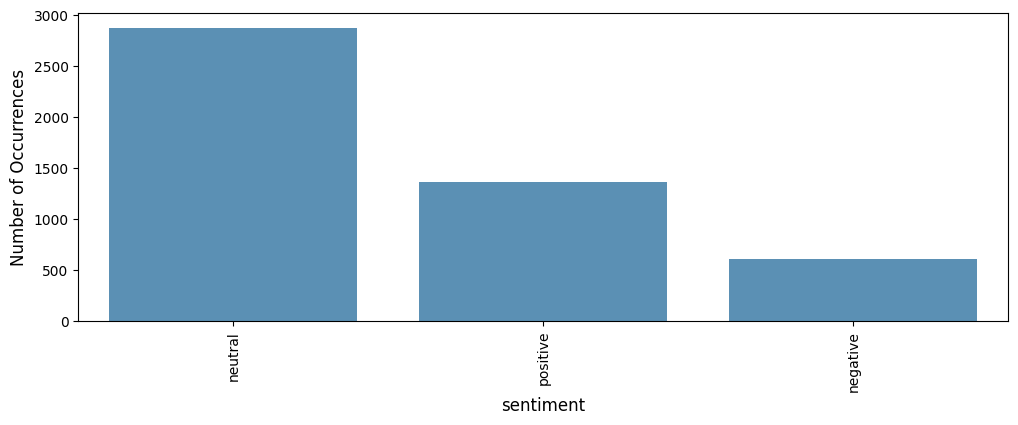

In [7]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt_pro.index, y = cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [8]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

      sentiment                                            Message
0             1  According to Gran , the company has no plans t...
1             1  Technopolis plans to develop in stages an area...
2             2  The international electronic industry company ...
3             0  With the new production plant the company woul...
4             0  According to the company 's updated strategy f...
...         ...                                                ...
4841          2  LONDON MarketWatch -- Share prices ended lower...
4842          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843          2  Operating profit fell to EUR 35.4 mn from EUR ...
4844          2  Net sales of the Paper segment decreased to EU...
4845          2  Sales in Finland decreased by 10.5 % in Januar...

[4846 rows x 2 columns]


In [9]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

A purchase agreement for 7,200 tons of gasoline with delivery at the Hamina terminal , Finland , was signed with Neste Oil OYj at the average Platts index for this September plus eight US dollars per month .
Message: 0


In [10]:
print_message(0)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Message: 1


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-11-1bb443366b7f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [12]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0 or word in stop_words: ## if len(word) <= 0
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

<ipython-input-11-1bb443366b7f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Found 4846 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4846, 50)


In [14]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['unc', 'charlotte', 'would', 'also', 'deploy', 'ssh', 'tectia', 'connector', 'enable', 'secure', 'application', 'connectivity', '.'], tags=[1]),
       TaggedDocument(words=['2009', ',', 'lee', '&', 'man', 'combined', 'annual', 'production', 'capacity', 'close', '4.5', 'million', 'tonnes', 'paper', '300,000', 'tonnes', 'pulp', '.'], tags=[1]),
       TaggedDocument(words=['``', "'s", 'high', 'figure', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'also', 'includes', 'beer', 'bought', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['products', 'include', 'consumer', 'electronics', 'devices', 'mobile', 'phones', 'accessories', ',', 'set-top', 'boes', ',', 'flat', 'panel', 'tvs', 'well', 'system', 'solutions', 'products', 'infrastructure', 'systems', ',', 'modules', 'industrial', 'segment', 'products', '.'], tags=[1]),
       TaggedDocument(words=['bridge', 'part', 'highway', '14', 'development', 

Model DM = 1

This work use DM=1 (it preserve word order)

In [15]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 4845/4845 [00:00<00:00, 1981222.86it/s]


In [16]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4845/4845 [00:00<00:00, 1449148.03it/s]


CPU times: user 10.7 s, sys: 88.5 ms, total: 10.8 s
Wall time: 15.7 s


In [17]:
print(d2v_model)


Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [18]:
len(d2v_model.wv.index_to_key)


11559

In [19]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

# Measuring distance between two vectors (related to cosine similarity)

In [20]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)


[('income', 0.8156010508537292),
 ('loss', 0.8069632649421692),
 ('29.4', 0.7924073338508606),
 ('writing', 0.7850239276885986),
 ('interiors', 0.7722282409667969),
 ('colors', 0.766916811466217),
 ('dans', 0.759617030620575),
 ('break-even', 0.7547102570533752),
 ('fancy', 0.7412893176078796),
 ('35.8', 0.7386695742607117)]

In [21]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)


[('luembourg-registered', 0.7898472547531128),
 ('roi', 0.7558265328407288),
 ('holdings', 0.7428624033927917),
 ('property', 0.7292940020561218),
 ('properties', 0.7289754152297974),
 ('ver', 0.7232036590576172),
 ('ilmarinen', 0.7049282789230347),
 ('varma', 0.6927581429481506),
 ('matka-vekka', 0.6832638382911682),
 ('construction', 0.681349515914917)]

In [22]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9580631852149963),
 ('aboavista', 0.9196449518203735),
 ('mursula', 0.8718428611755371),
 ('want', 0.8684328198432922),
 ('urls', 0.8602123856544495),
 ('cautious', 0.8591155409812927),
 ('eager', 0.8584463000297546),
 ("'m", 0.8559736013412476),
 ('macro-economic', 0.8557884693145752),
 ('artemyev', 0.8526414036750793)]

Plot Similarity word in Doc2vec

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.key_to_index:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(50):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

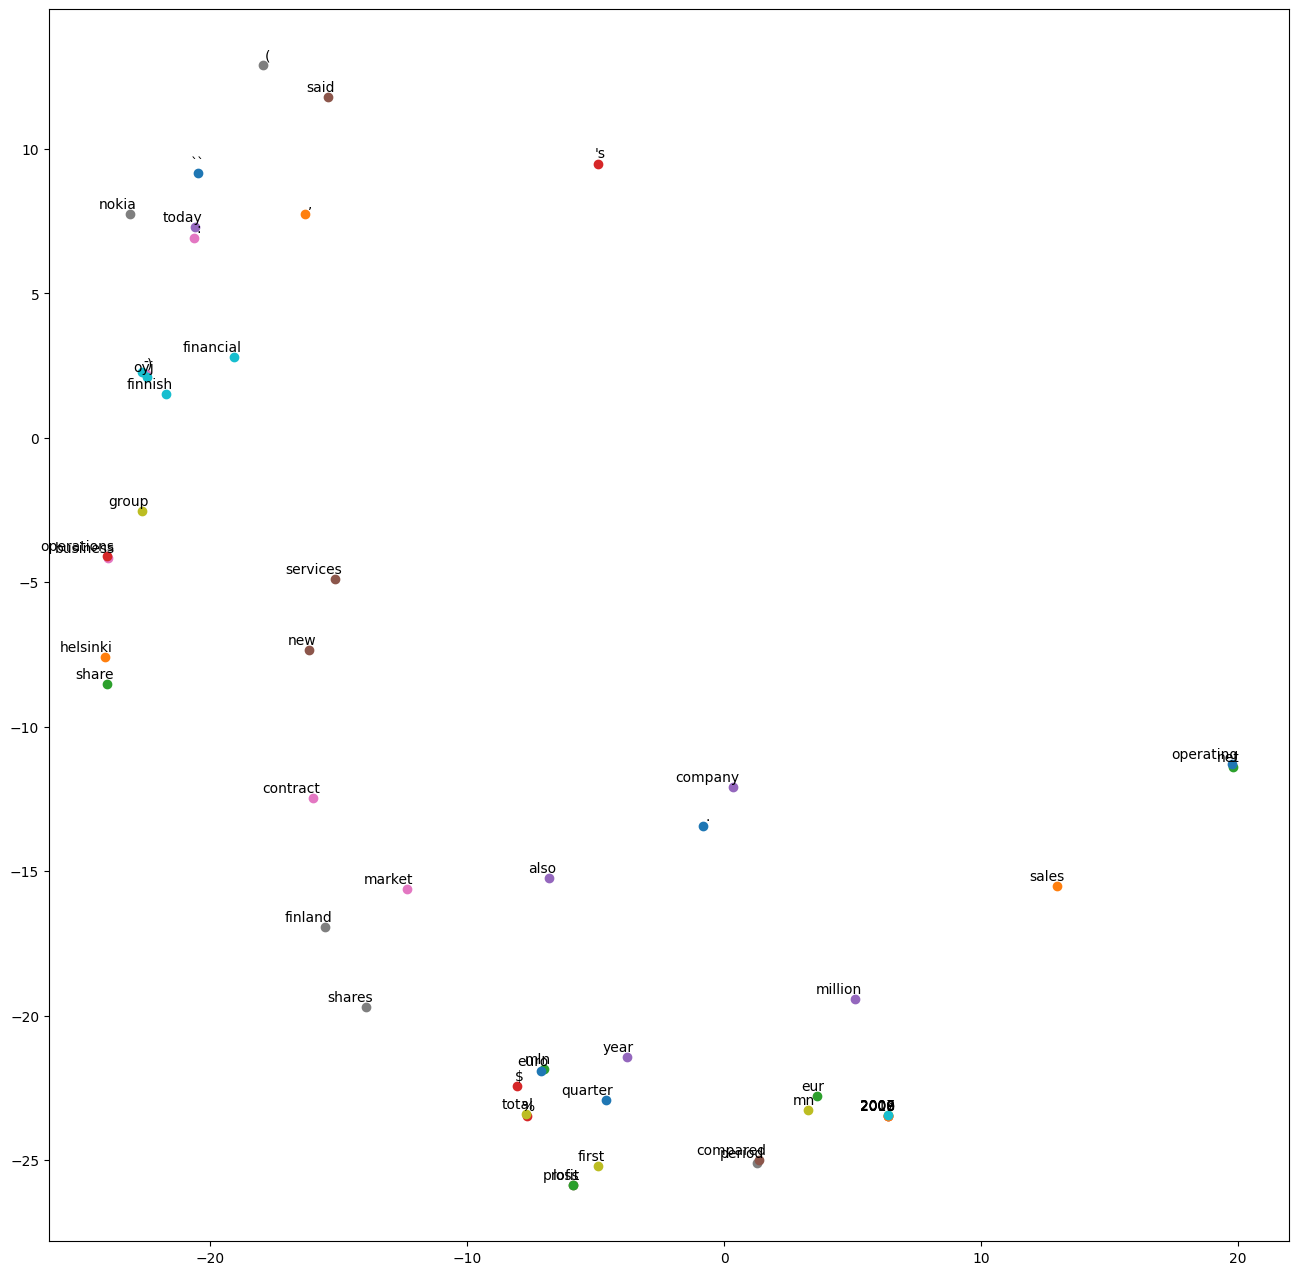

In [24]:
tsne_plot(d2v_model)

# Create the LSTM Model

The parameter used here inspired by [3].



In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            231200    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 245553 (959.19 KB)
Trainable params: 245553 (959.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


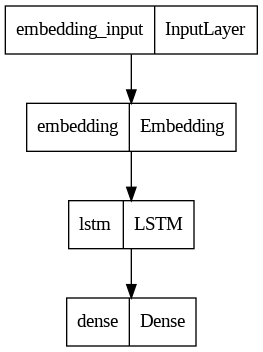

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [27]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4119, 50) (4119, 3)
(727, 50) (727, 3)


In [28]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 4s - loss: 0.5518 - acc: 0.5950 - 4s/epoch - 29ms/step
Epoch 2/50
129/129 - 2s - loss: 0.4273 - acc: 0.6953 - 2s/epoch - 16ms/step
Epoch 3/50
129/129 - 2s - loss: 0.3077 - acc: 0.7849 - 2s/epoch - 17ms/step
Epoch 4/50
129/129 - 3s - loss: 0.2396 - acc: 0.8296 - 3s/epoch - 21ms/step
Epoch 5/50
129/129 - 2s - loss: 0.1996 - acc: 0.8585 - 2s/epoch - 16ms/step
Epoch 6/50
129/129 - 2s - loss: 0.1695 - acc: 0.8958 - 2s/epoch - 16ms/step
Epoch 7/50
129/129 - 2s - loss: 0.1120 - acc: 0.9376 - 2s/epoch - 16ms/step
Epoch 8/50
129/129 - 2s - loss: 0.0700 - acc: 0.9663 - 2s/epoch - 16ms/step
Epoch 9/50
129/129 - 3s - loss: 0.0462 - acc: 0.9786 - 3s/epoch - 20ms/step
Epoch 10/50
129/129 - 2s - loss: 0.0361 - acc: 0.9825 - 2s/epoch - 18ms/step
Epoch 11/50
129/129 - 2s - loss: 0.0300 - acc: 0.9876 - 2s/epoch - 16ms/step
Epoch 12/50
129/129 - 2s - loss: 0.0315 - acc: 0.9859 - 2s/epoch - 16ms/step
Epoch 13/50
129/129 - 2s - loss: 0.0297 - acc: 0.9869 - 2s/epoch - 16ms/step
Epoch 14

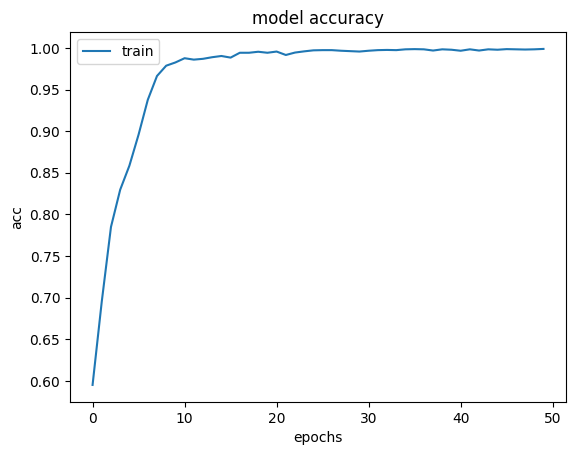

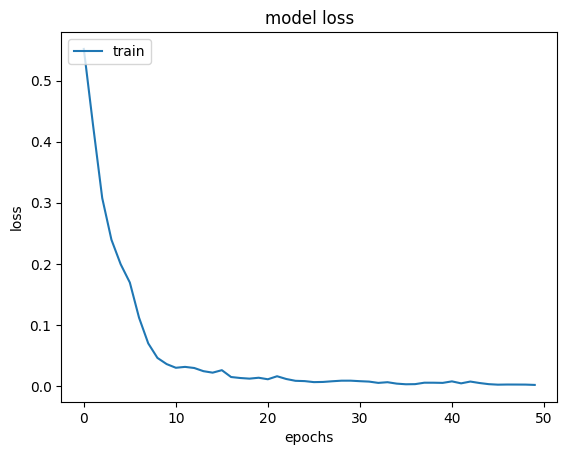

<Figure size 640x480 with 0 Axes>

In [29]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [30]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0016 - acc: 0.9988 - 1s/epoch - 8ms/step
23/23 - 0s - loss: 1.1400 - acc: 0.7552 - 129ms/epoch - 6ms/step
Train: 0.999, Test: 0.7552


In [31]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
yhat_classes = np.argmax(yhat_classes,axis=1)

[[2.9061837e-08 9.9999994e-01 9.1912273e-09]
 [7.8018987e-11 9.9999994e-01 4.7632506e-11]
 [9.9999994e-01 5.2813935e-08 1.3483185e-08]
 ...
 [1.4768781e-08 1.0000000e+00 6.5207768e-09]
 [5.4246349e-05 9.9994361e-01 2.1682692e-06]
 [4.2030723e-03 9.9316698e-01 2.6300496e-03]]
[[0 1 0]
 [0 1 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


In [32]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1,
       0, 2, 0, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2,
       1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0,

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[132,  76,   8],
       [ 46, 372,   9],
       [ 12,  27,  45]])

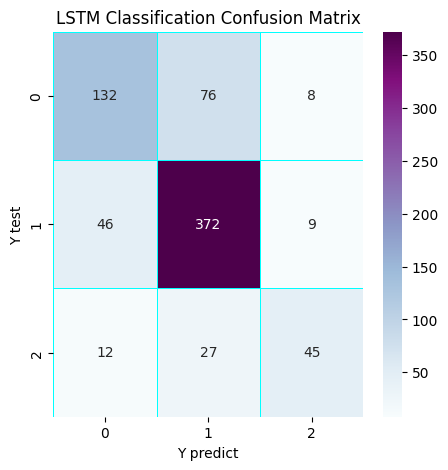

In [34]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [35]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 6ms/step - loss: 0.9320 - acc: 0.7778
score: 0.93
acc: 0.78


**Save Model**


In [36]:

model.save('Mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2}

In [44]:
message = ['Apple is doing very well in this lousy economy.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['positive','neutral','negative']
print(message[0])
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")


1/1 [==============================] - 0s 59ms/step
Apple is doing very well in this lousy economy.
probability of positive class: 0.9828333854675293
probability of neutral class: 0.003437405452132225
probability of negative class: 0.013729089871048927
predicted class: positive


In [45]:
message = ['Congratulations! you have won $1,000']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")


1/1 [==============================] - 0s 19ms/step
Congratulations! you have won $1,000
probability of positive class: 0.008085587993264198
probability of neutral class: 0.9902400970458984
probability of negative class: 0.0016743241576477885
predicted class: neutral


In [46]:
message = ['Europe faces an unusual problem: ultra-cheap energy']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")

1/1 [==============================] - 0s 26ms/step
Europe faces an unusual problem: ultra-cheap energy
probability of positive class: 0.01670153997838497
probability of neutral class: 0.9822993874549866
probability of negative class: 0.000999073265120387
predicted class: neutral


In [47]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")

1/1 [==============================] - 0s 17ms/step
The local electronics industry is amid layoff concerns and last year has laid off tens of employees
probability of positive class: 3.909645158728381e-07
probability of neutral class: 4.1666365291348484e-07
probability of negative class: 0.9999991655349731
predicted class: negative


In [48]:
message = ['US banks suffer steeper losses']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")

1/1 [==============================] - 0s 18ms/step
US banks suffer steeper losses
probability of positive class: 0.2637346386909485
probability of neutral class: 0.00690743001177907
probability of negative class: 0.729357898235321
predicted class: negative


In [49]:
message = ['US banks suffer steeper losses, but retain large cushions in annual Fed health check']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")

1/1 [==============================] - 0s 19ms/step
US banks suffer steeper losses, but retain large cushions in annual Fed health check
probability of positive class: 2.6937430064322143e-09
probability of neutral class: 1.0
probability of negative class: 4.479181914263108e-09
predicted class: neutral


In [53]:
message = ['Biden says debate was bad episode']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)
print(message[0])
labels = ['positive','neutral','negative']
print(f"probability of positive class: {pred[0][sentiment['positive']]}")
print(f"probability of neutral class: {pred[0][sentiment['neutral']]}")
print(f"probability of negative class: {pred[0][sentiment['negative']]}")
print(f"predicted class: {labels[np.argmax(pred)]}")

1/1 [==============================] - 0s 29ms/step
Biden says debate was bad episode
probability of positive class: 0.32925793528556824
probability of neutral class: 0.32904791831970215
probability of negative class: 0.3416941165924072
predicted class: negative
